# Notes on Auriga

This uses different parameters to TNG. In particular 
- SNII Mass Range $[8,100]\,M_\odot$ (matching TNG)
- AGB Mass Range $[1,8]\,M_\odot$ (matching TNG)
- IMF Mass Range $[0.1,100]\,M_\odot$ (matching TNG)
- SN$\,$II Yields - Portinari (1998) (matching Illustris)
- AGB Yields - Karakas (2010) (matching Illustris)
- SN$\,$Ia Yields - Thielemann (2003) \& Travaglio (2004) (matching Illustris)
- SN$\,$Ia DTD uses $N_0 = 1.99 \times 1.3\times 10^{-3}$ - does this change $N_\mathrm{Ia}$? (same as TNG)

#### Load in Auriga z = 0 Mock

In [223]:
input_filename='/mnt/store1/oliverphilcox/ChempyMultiData/Auriga/snapshot_reduced_halo_6_063.hdf5'

#### First read in quantities

In [224]:
import h5py
with h5py.File(input_filename) as f:
    h=f['Header']
    Omega0=h.attrs.get('Omega0')
    OmegaLambda=h.attrs.get('OmegaLambda')
    HubbleParam=h.attrs.get('HubbleParam')
    z=h.attrs.get('Redshift')
    all_metal_fractions = f['PartType4']['GFM_Metals'][:]
    metal_names=['H', 'He', 'C', 'N','O','Ne', 'Mg', 'Si', 'Fe']
    star_age= f['PartType4']['GFM_StellarFormationTime'][:]
    #initial_mass = f['PartType4']['GFM_InitialMass'].value

#### Compute age

In [225]:
from astropy.cosmology import FlatLambdaCDM

In [226]:
model=FlatLambdaCDM(100*HubbleParam,Omega0,Tcmb0=2.725)
univ_age=model.age(0).value

#### Convert to abundances

In [227]:
# Import solar abundances
import os
%pylab inline
os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.solar_abundance import solar_abundances
solar=solar_abundances()
getattr(solar,'Asplund09')()#5_pure_solar')()

# First get correct photospheric abundances and masses
good_els = metal_names
el_masses=np.zeros(len(good_els))
phot_abuns=np.zeros(len(good_els))
no_fractions = np.zeros([len(all_metal_fractions),len(good_els)])
for e,el in enumerate(good_els):
    for i in range(len(solar.all_elements)):
        if solar.all_elements[i]==el:
            el_masses[e]=solar.all_element_masses[i]
            phot_abuns[e]=solar.table['photospheric'][i]
            break
        if i==len(solar.all_elements)-1:
            raise Exception('Failed to find element %s'%el)
    if el=='Fe':
        Fe_index = e
    if el=='H':
        H_index = e
    no_fractions[:,e]=all_metal_fractions[:,e]/el_masses[e]

# Now normalize by H and find [X/H] abundances:
star_abun=np.zeros_like(no_fractions)
for e in range(len(good_els)):
    star_abun[:,e] = np.log10(no_fractions[:,e]/no_fractions[:,H_index])+12.-phot_abuns[e]
    
# Now convert to [X/Fe] abuns:
for e,el in enumerate(good_els):
    if el!='Fe':
        star_abun[:,e]-=star_abun[:,Fe_index]
    else:
        pass # keep Fe/H form
    
# Now reorder to match TNG
el_names = ['C','Fe','He','Mg','N','Ne','O','Si'] # TNG elements
TNG_abun = np.zeros([len(star_abun),len(el_names)])
for e,el in enumerate(el_names):
    for m in range(len(good_els)):
        if good_els[m]==el:
            TNG_abun[:,e]=star_abun[:,m]
            break



Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract


#### Convert to star formation time rather than age

In [228]:
star_formation_times = univ_age-star_age

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


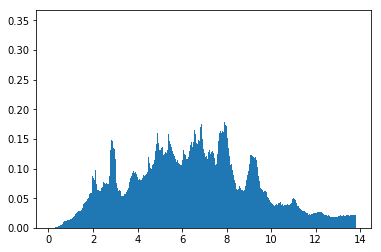

In [229]:
%pylab inline
plt.hist(star_formation_times,bins=1000,density=True);

#### Save all data:

In [230]:
np.savez('/mnt/store1/oliverphilcox/ChempyMultiData/Auriga/All_Auriga_abundances.npz',
         birth_time=star_formation_times,elements=el_names,abundance=TNG_abun)

#### Filter out any with $T<2$Gyr, or $T>13$Gyr to avoid errors:

In [231]:
good_index=np.where((star_formation_times>2.)&(star_formation_times<12.8))
TNG_abuns = TNG_abun[good_index]
TNG_times = star_formation_times[good_index]
good_index2=np.where(np.max(np.abs(TNG_abuns),axis=1)<3.)
TNG_abuns = TNG_abuns[good_index2]
TNG_times = TNG_times[good_index2]

In [232]:
ab_error = 0.05
time_error = 0.3

In [233]:
TNG_abun_err = np.ones_like(TNG_abuns)*ab_error
TNG_times_err = (TNG_times*time_error).round(2)

In [234]:
TNG_obs_abuns =np.random.normal(loc=TNG_abuns,scale=TNG_abun_err).round(2)
TNG_obs_times=np.random.normal(loc=TNG_times,scale=TNG_times_err).round(2)

#### First randomize these particles + remove any with bad time values:

In [235]:
jitter = np.random.choice(range(len(TNG_abuns)),replace=False,size=len(TNG_abuns))
TNG_abuns=TNG_abuns[jitter]
TNG_times=TNG_times[jitter]
TNG_obs_abuns=TNG_obs_abuns[jitter]
TNG_abun_err=TNG_abun_err[jitter]
TNG_times_err=TNG_times_err[jitter]
TNG_obs_times=TNG_obs_times[jitter]

filt = np.where((TNG_obs_times>2.)&(TNG_obs_times<13.8))
TNG_abuns=TNG_abuns[filt]
TNG_times=TNG_times[filt]
TNG_obs_abuns=TNG_obs_abuns[filt]
TNG_abun_err=TNG_abun_err[filt]
TNG_times_err=TNG_times_err[filt]
TNG_obs_times=TNG_obs_times[filt]


#### Now save output:

In [236]:
np.savez('/mnt/store1/oliverphilcox/ChempyMultiData/Auriga/Auriga_Mock_Data_Full.npz',
        elements=el_names,abundances=TNG_obs_abuns,abundance_errs=TNG_abun_err,true_time=TNG_times,
        obs_time=TNG_obs_times,obs_time_err=TNG_times_err,true_abuns=TNG_abuns)

#### Also save cut down output

In [237]:
np.savez('/mnt/store1/oliverphilcox/ChempyMultiData/Auriga/Auriga_Mock_Data_Cut.npz',galaxy_index=id,
        elements=el_names,abundances=TNG_obs_abuns[:100000],abundance_errs=TNG_abun_err[:100000],true_time=TNG_times[:100000],
        obs_time=TNG_obs_times[:100000],obs_time_err=TNG_times_err[:100000],true_abuns=TNG_abuns[:100000])

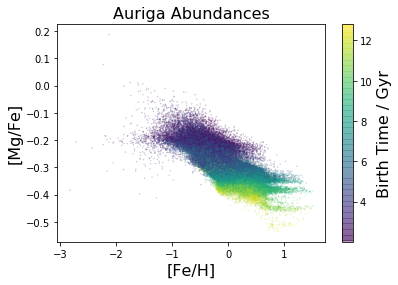

In [238]:
FS=16
aur=np.load("/mnt/store1/oliverphilcox/ChempyMultiData/Auriga/Auriga_Mock_Data_Cut.npz")
MgFeAur=aur.f.true_abuns[:,3]
HeFeAur=aur.f.true_abuns[:,2]
FeHAur=aur.f.true_abuns[:,1]
timesAur=aur.f.true_time
plt.scatter(FeHAur,MgFeAur,alpha=0.4,s=0.1,c=timesAur)
cb=plt.colorbar();
cb.set_label('Birth Time / Gyr',fontsize=FS)
plt.ylabel(r'[Mg/Fe]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
plt.title('Auriga Abundances',fontsize=FS);
#plt.xlim([-1.7,0.6]);plt.ylim([0.1,0.9]);